In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import copy

from rembg import remove

import open3d as o3d
from open3d.visualization import draw_geometries

from process_bag import get_images
from utils import get_o3d_intrinsics, colordepth_to_rgbd, rgbd_to_pcd, remove_outliers
from utils import finetune_corners, gen_cameras, gen_pcds, align_pcds
from utils import show_imgs, draw_axis, read_colmap_array

depth_intrinsics, color_intrinsics = get_o3d_intrinsics()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Chessboard size
cb_counts = (4, 7)
cb_scale = 2
cb_size = 0.033 * cb_scale

# Rendering settings
voxel_size = 0.02
camera_size = 2 * cb_size
# origin_size = 4 * cb_size
origin_size = 1

kwargs = dict(
    zoom=0.5,
    front=[0.0, 0.0, -1.0],
    lookat=[0.0, 0.0, 0.0],
    up=[1.0, 0, 0],
)
kwargs = dict(
    zoom=1.0,
    front=[0.0, 0.0, -1.0],
    lookat=[0.0, 0.0, 0.0],
    up=[0, 1.0, 0],
)

# data_name = "books_2"
data_name = "bear"

data_name_raw = data_name.split("_")[0]
data_folder = f"data/{data_name}"

# mkdir imgs, npys, plys, plys_final
for folder in ["imgs", "npys", "plys", "plys_final"]:
    os.makedirs(os.path.join(data_folder, folder), exist_ok=True)

color_fp = os.path.join(data_folder, "npys/color.npy")
depth_fp = os.path.join(data_folder, "npys/depth.npy")
color_single_fp = os.path.join(data_folder, "npys/color_single.npy")
depth_single_fp = os.path.join(data_folder, "npys/depth_single.npy")

In [3]:
# Setup origin
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=origin_size, origin=[0,0,0])
origin2 = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=origin_size, origin=[0,0,0])
origin2.rotate(R=np.array([[-1,0,0],[0,-1,0],[0,0,-1]]), center=[0,0,0])
origin2.paint_uniform_color([0,1,1])

origin_both = o3d.geometry.TriangleMesh()
origin_both += origin
origin_both += origin2

### Read BAGs

In [4]:
# Load/Process Data
def get_imgs(color_fp, depth_fp, start_idx, end_idx, align=True):
    if os.path.exists(color_fp) and os.path.exists(depth_fp):
        color_imgs = np.load(color_fp)
        depth_imgs = np.load(depth_fp)
    else:
        color_imgs = []
        depth_imgs = []
        fps = sorted(glob.glob(f'{data_folder}/bags/*.bag'))
        for i, fp in enumerate(fps):
            if not os.path.exists(fp):
                continue
            if i % 10 == 0:
                print(f"Processing bag {i+1}/{len(fps)} {fp}")
            color_img, depth_img = get_images(
                start_idx=start_idx,
                end_idx=end_idx,
                bag_fp=fp,
                align=align,
                median=True
            )
            color_imgs.append(color_img)
            depth_imgs.append(depth_img)
        color_imgs = np.stack(color_imgs)
        depth_imgs = np.stack(depth_imgs)
        np.save(color_fp, color_imgs)
        np.save(depth_fp, depth_imgs)
    
    # Depth to meters
    depth_imgs = depth_imgs.astype(np.float32) / 1000.0
    return color_imgs, depth_imgs

color_imgs, depth_imgs = get_imgs(color_fp, depth_fp, 0, 30)
color_imgs_single, depth_imgs_single = get_imgs(
    color_single_fp, depth_single_fp, 5, 6)

color_imgs.shape, depth_imgs.shape, color_imgs_single.shape, depth_imgs_single.shape

((211, 480, 640, 3), (211, 480, 640), (211, 480, 640, 3), (211, 480, 640))

In [5]:
# Remove background
save_dir = os.path.join(data_folder, "npys/color_nobg.npy")

if not os.path.exists(save_dir):
    color_imgs_nobg = []
    for i in tqdm(range(len(color_imgs))):
        color_img = color_imgs[i]
        color_img_nobg = remove(color_img)
        color_imgs_nobg.append(color_img_nobg)
    color_imgs_nobg = np.stack(color_imgs_nobg)
    np.save(save_dir, color_imgs_nobg)
else:
    color_imgs_nobg = np.load(save_dir)
color_imgs_nobg.shape

(211, 480, 640, 4)

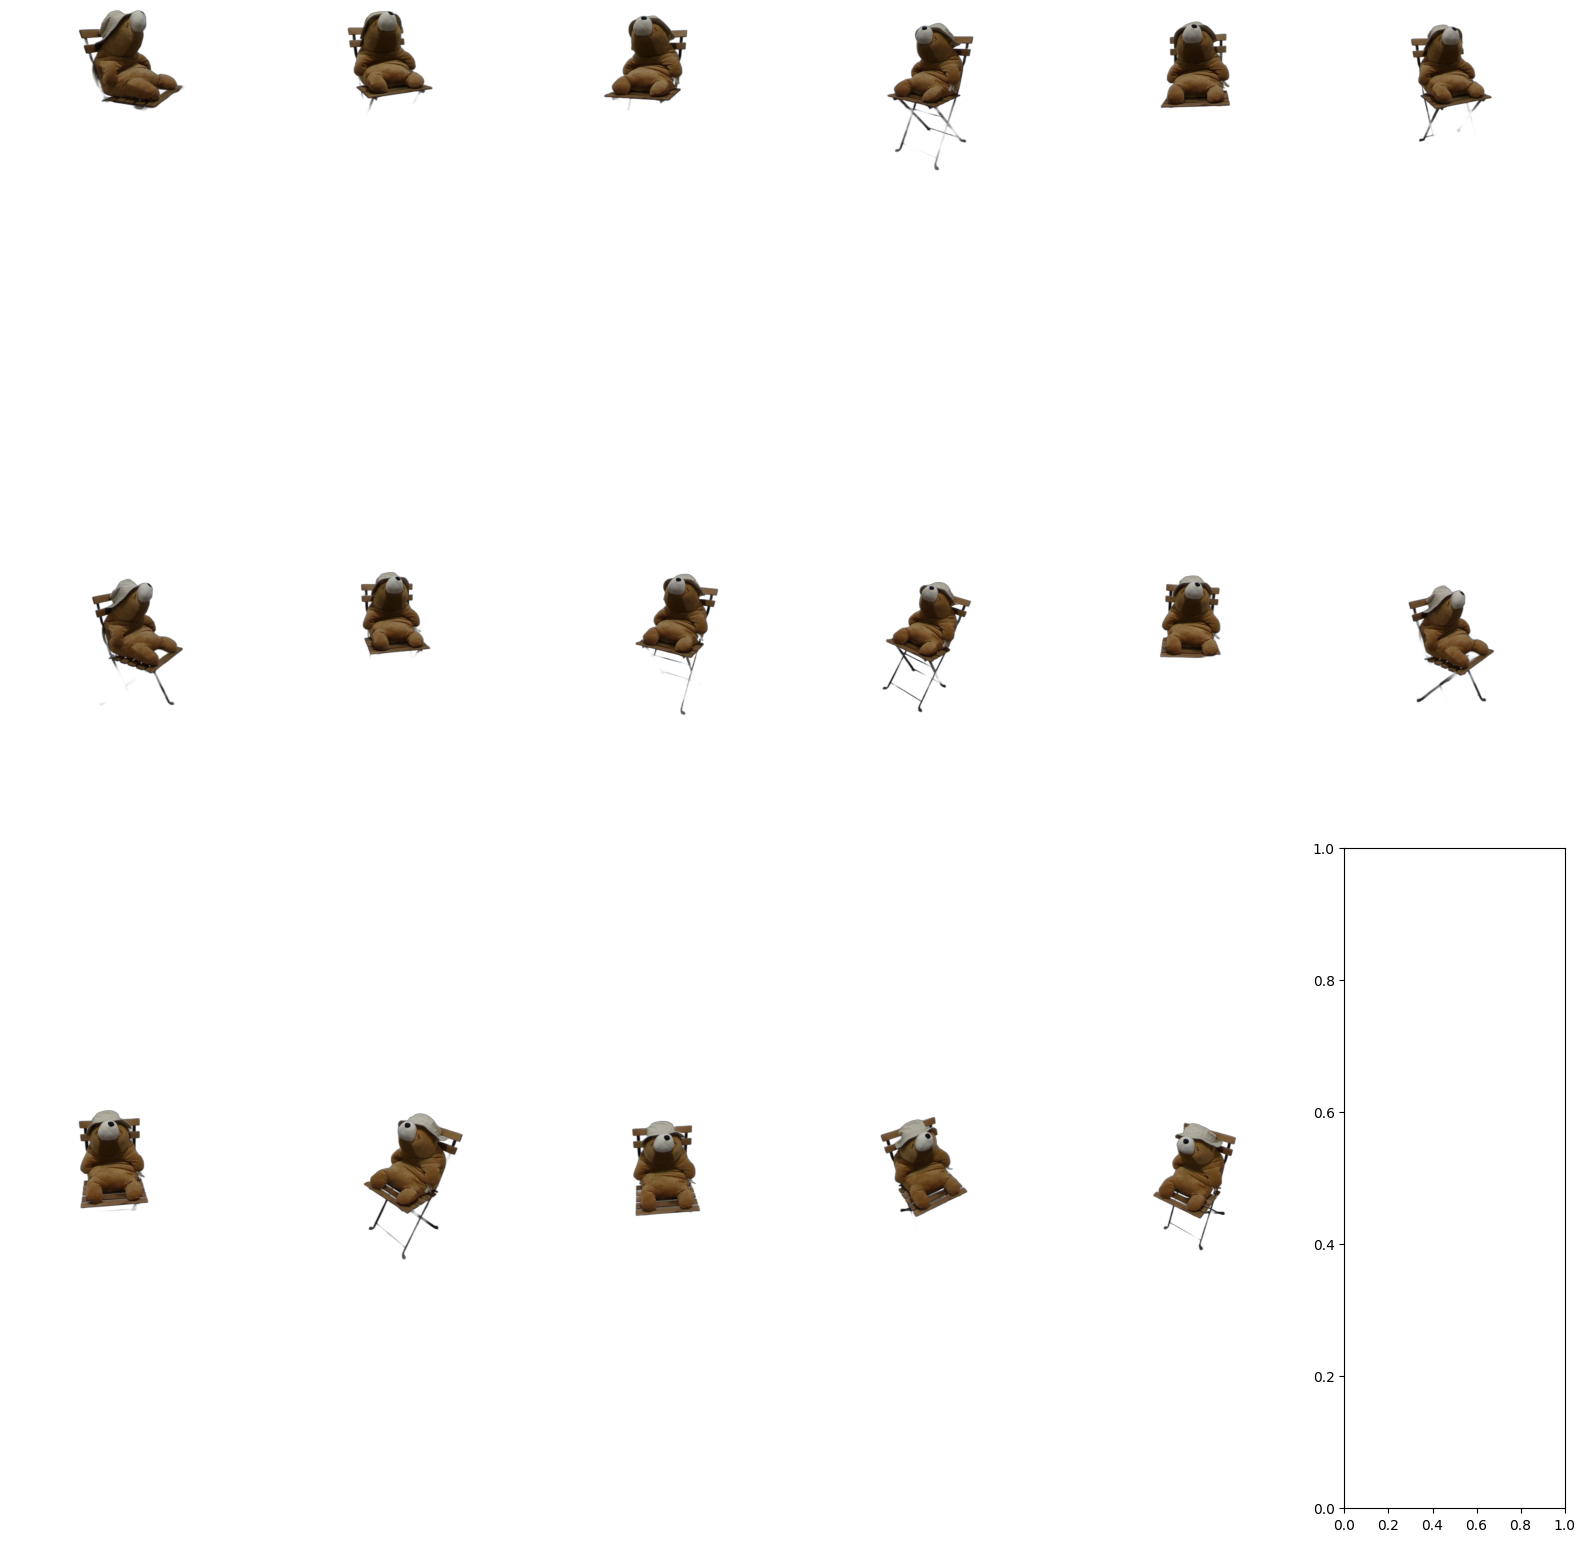

In [6]:
show_imgs(color_imgs_nobg[::13], width=6)

In [7]:
# Save images for colmap
colmap = True
fps = []

save_dir = os.path.join(data_folder, "imgs")
for i in tqdm(range(len(color_imgs_nobg))):
    fp = os.path.join(save_dir, f"color_{i}.png")
    fps.append(fp)
    if os.path.exists(fp):
        continue
    img = color_imgs_nobg[i].copy()
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGRA)
    cv2.imwrite(fp, img)

100%|██████████| 211/211 [00:00<00:00, 175490.41it/s]


In [8]:
# update color_imgs (alpha to white)
color_imgs = color_imgs_nobg[:, :, :, :3].copy()
alpha = color_imgs_nobg[:, :, :, 3].copy() / 255.0

color_imgs = color_imgs[:, :, :, :3] * alpha[:, :, :, None] + 255 * (1 - alpha[:, :, :, None])
color_imgs = color_imgs.astype(np.uint8)

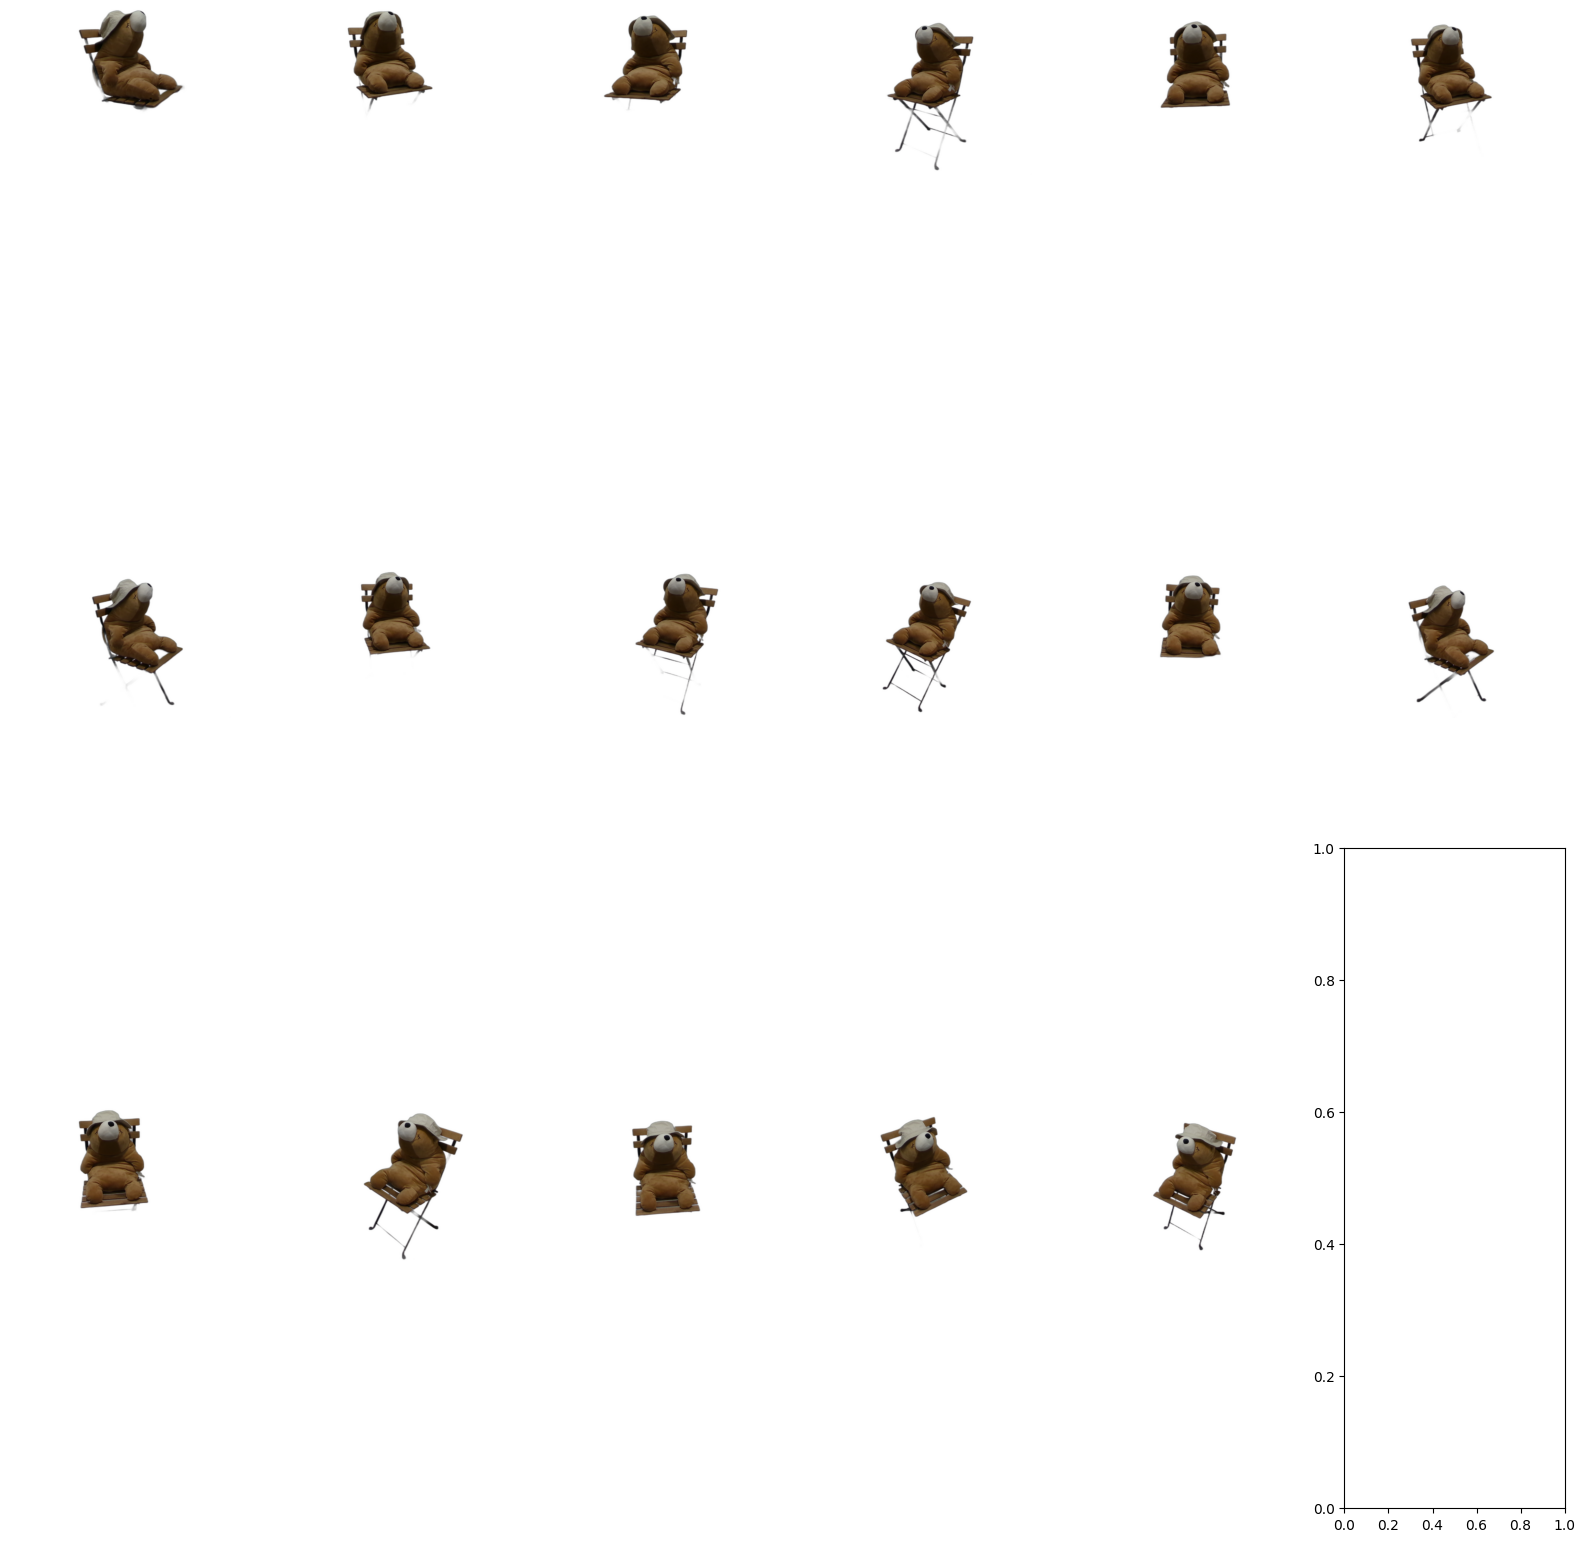

In [9]:
show_imgs(color_imgs[::13], width=6)

### COLMAP

In [10]:
# Read cameras.txt
colmap_folder = os.path.join(data_folder, "sparse/0")
cameras_fp = os.path.join(colmap_folder, "cameras.txt")
images_fp = os.path.join(colmap_folder, "images.txt")

cameras_lines = []
images_lines = []
with open(cameras_fp, "r") as f:
    cameras_lines = [l.strip() for l in f.readlines() if l[0] != "#"]
with open(images_fp, "r") as f:
    images_lines = [l.strip() for l in f.readlines() if l[0] != "#"]

In [11]:
_, _, w, h, focal, ppx, ppy, dist_k = cameras_lines[0].strip().split(" ")
w, h, focal, ppx, ppy, dist_k = int(w), int(h), float(focal), float(ppx), float(ppy), float(dist_k)
intrinsics = o3d.camera.PinholeCameraIntrinsic(w, h, focal, focal, ppx, ppy)

print(f"Camera: {w}x{h}")
print(f"dist_k: {dist_k}")
print(f"Camera intrinsics:\n{intrinsics.intrinsic_matrix}")
print(f"Color intrinsics:\n{color_intrinsics.intrinsic_matrix}")

Camera: 640x480
dist_k: 0.04254732219492363
Camera intrinsics:
[[580.21465281   0.         320.        ]
 [  0.         580.21465281 240.        ]
 [  0.           0.           1.        ]]
Color intrinsics:
[[617.13928223   0.         318.18209839]
 [  0.         617.77008057 252.93757629]
 [  0.           0.           1.        ]]


In [12]:
from scipy.spatial.transform import Rotation as R

# IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
pose_lines = [l for l in images_lines if l.endswith(".png")]
pose_lines = [l.split(" ") for l in pose_lines]

colmap_data = {}
for pose_line in pose_lines:
    # Quaternion and translation
    _, qw, qx, qy, qz, tx, ty, tz, _, name = pose_line
    qw, qx, qy, qz, tx, ty, tz = float(qw), float(qx), float(qy), float(qz), float(tx), float(ty), float(tz)

    # Convert to rotation matrix
    r = R.from_quat([qx, qy, qz, qw])
    rot_mat = r.as_matrix()
    t = np.array([tx, ty, tz])

    # Convert to extrinsics matrix (4x4)
    c2w = np.eye(4)
    c2w[:3, :3] = rot_mat
    c2w[:3, 3] = t

    # Convert to camera-to-world matrix (4x4)
    c2w = np.linalg.inv(c2w)
    colmap_data[name] = {
        "c2w": c2w,
    }

len(colmap_data), list(colmap_data.keys())[:5]

(211,
 ['color_0.png',
  'color_1.png',
  'color_10.png',
  'color_100.png',
  'color_102.png'])

In [13]:
# Read images
images_folder = os.path.join(data_folder, "dense/0/images")
depth_map_folder = os.path.join(data_folder, "dense/0/stereo/depth_maps")

geo_count, photo_count = 0, 0
for file_name in colmap_data.keys():
    color = cv2.imread(os.path.join(images_folder, file_name))
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    colmap_data[file_name]["color"] = color

    # Load Depth Maps
    geo_fp = os.path.join(depth_map_folder, f"{file_name}.geometric.bin")
    photo_fp = os.path.join(depth_map_folder, f"{file_name}.photometric.bin")
    if os.path.exists(geo_fp):
        colmap_data[file_name]["geo_depth"] = read_colmap_array(geo_fp)
        geo_count += 1
    if os.path.exists(photo_fp):
        colmap_data[file_name]["photo_depth"] = read_colmap_array(photo_fp)
        photo_count += 1

print(f"Geometric depth maps: {geo_count}")
print(f"Photometric depth maps: {photo_count}")

Geometric depth maps: 211
Photometric depth maps: 211


In [14]:
colmap_color = []
colmap_depth = []
colmap_c2w = []
for i in range(len(colmap_data)):
    file_name = f"color_{i}.png"
    colmap_color.append(colmap_data[file_name]["color"])
    # colmap_depth.append(colmap_data[file_name]["photo_depth"])
    colmap_depth.append(colmap_data[file_name]["geo_depth"])
    colmap_c2w.append(colmap_data[file_name]["c2w"])

colmap_color = np.stack(colmap_color)
colmap_depth = np.stack(colmap_depth)
colmap_c2w = np.stack(colmap_c2w)

colmap_color.shape, colmap_depth.shape, colmap_c2w.shape

((211, 469, 626, 3), (211, 469, 626), (211, 4, 4))

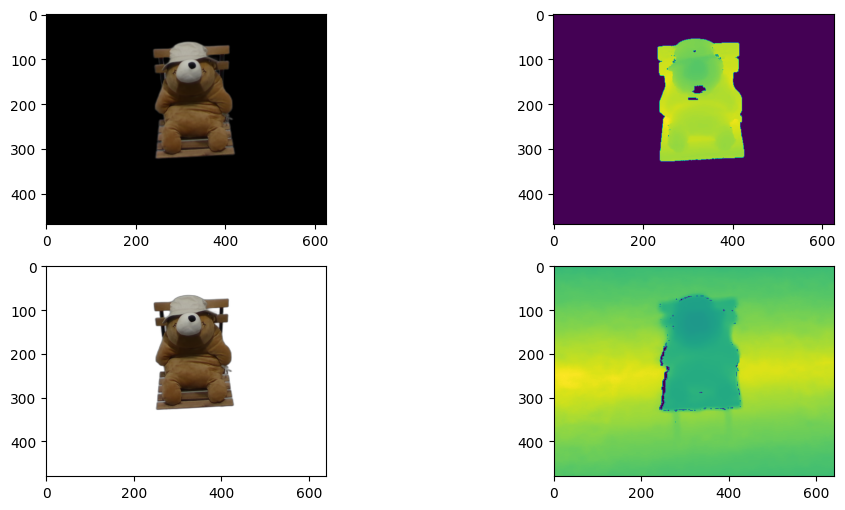

In [17]:
idx = 200
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes[0, 0].imshow(colmap_color[idx])
axes[0, 1].imshow(colmap_depth[idx])
axes[1, 0].imshow(color_imgs_nobg[idx])
axes[1, 1].imshow(depth_imgs[idx])

In [18]:
# Reload imported modules
import importlib
import utils

importlib.reload(utils)

from utils import *

In [19]:
# Load fused
fused_fp = os.path.join(data_folder, "dense/0/fused.ply")
fused = o3d.io.read_point_cloud(fused_fp)
fused = o3d.geometry.PointCloud.voxel_down_sample(fused, voxel_size=0.04)
fused

PointCloud with 32779 points.

In [20]:
# Cameras
cameras_colmap = gen_cameras(colmap_c2w, camera_size)
draw_geometries([origin_both] + cameras_colmap + [fused])

In [21]:
colmap_pcds = gen_pcds(colmap_color, colmap_depth, intrinsics, cb_scale=1.0, depth_scale=1.0)
colmap_pcds_align = align_pcds(colmap_pcds, colmap_c2w, voxel_size=0.04)
colmap_pcds_align[:10]

[PointCloud with 9641 points.,
 PointCloud with 9541 points.,
 PointCloud with 9600 points.,
 PointCloud with 9534 points.,
 PointCloud with 9687 points.,
 PointCloud with 9710 points.,
 PointCloud with 9895 points.,
 PointCloud with 9942 points.,
 PointCloud with 9921 points.,
 PointCloud with 10123 points.]

In [22]:
# Clean up outliers
for i in range(len(colmap_pcds_align)):
    colmap_pcds_align[i] = remove_outliers(
        colmap_pcds_align[i],
        nb_neighbors=50,
        std_ratio=0.5,
    )
colmap_pcds_align[:10]

[PointCloud with 7837 points.,
 PointCloud with 7728 points.,
 PointCloud with 7696 points.,
 PointCloud with 7700 points.,
 PointCloud with 7833 points.,
 PointCloud with 7838 points.,
 PointCloud with 8121 points.,
 PointCloud with 8261 points.,
 PointCloud with 8272 points.,
 PointCloud with 8594 points.]

In [23]:
draw_geometries([origin_both] + cameras_colmap + colmap_pcds_align,
    zoom=0.5, front=[0, 0, -1], lookat=[0, 0, 0], up=[0, -1, 0])

In [24]:
# fuse and paint green
fused_colmap = o3d.geometry.PointCloud()
for pcd in colmap_pcds_align:
    fused_colmap += pcd

fused_colmap.paint_uniform_color([0, 1, 0])
fused_colmap = o3d.geometry.PointCloud.voxel_down_sample(fused_colmap, voxel_size=0.04)

# color fused
fused.paint_uniform_color([1, 0, 0])

fused_colmap

PointCloud with 71283 points.

In [25]:
draw_geometries([origin_both, fused, fused_colmap] + cameras_colmap,
    zoom=0.5, front=[0, 0, -1], lookat=[0, 0, 0], up=[0, -1, 0])

In [26]:
_, h, w = depth_imgs.shape

scan_depths = []
cm_depths = []
valid_fracs = []

for idx in range(len(depth_imgs)):
    # Scanned depth map
    scan_depth = depth_imgs[idx].copy()

    # Colmap depth map
    file_name = f"color_{idx}.png"
    cm_depth = colmap_data[file_name]["photo_depth"]
    # Resize to match scan depth map
    cm_depth = cv2.resize(cm_depth, (w, h), interpolation=cv2.INTER_NEAREST)

    # Alpha mask
    msk = color_imgs_nobg[idx][:, :, 3].copy() / 255.0
    # Mask all pixels with depth > 0
    msk *= (cm_depth > 0) & (scan_depth > 0)

    scan_depths.append(scan_depth * msk)
    cm_depths.append(cm_depth * msk)
    valid_fracs.append(msk.sum() / msk.size)

scan_depths = np.stack(scan_depths)
cm_depths = np.stack(cm_depths)
valid_fracs = np.stack(valid_fracs)

scan_depths.shape, cm_depths.shape, valid_fracs.shape

((211, 480, 640), (211, 480, 640), (211,))

In [27]:
# Use torch and optimize for multiplier scale
import torch

def find_scale(mat1, mat2, weights):
    mat1 = torch.from_numpy(mat1).float()
    mat2 = torch.from_numpy(mat2).float()
    weights = torch.from_numpy(weights).float()[:, None, None]

    # Optimize scale
    scale = torch.ones(1)
    scale.requires_grad = True

    optimizer = torch.optim.SGD([scale], lr=0.01, momentum=0.8)

    epochs = 100
    for i in range(epochs):
        optimizer.zero_grad()
        loss = torch.mean(weights * torch.pow(mat1 - scale * mat2, 2))
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f"Loss: {loss.item():.6f}")

    scale = scale.detach().numpy()[0]
    print(f"Scale: {scale:.4f}")
    return scale

In [28]:
# Back to numpy
scale = find_scale(scan_depths, cm_depths, valid_fracs)

print(f"Initial norm: {np.linalg.norm(scan_depths - cm_depths):.4f}")
cm_depths = cm_depths * scale
print(f"Final norm: {np.linalg.norm(scan_depths - cm_depths):.4f}")

Loss: 0.450909
Loss: 0.168763
Loss: 0.026661
Loss: 0.002942
Loss: 0.000762
Loss: 0.000666
Loss: 0.000666
Loss: 0.000666
Loss: 0.000665
Loss: 0.000665
Scale: 0.1850
Initial norm: 15992.4020
Final norm: 613.0426


In [29]:
# Draw fused and cameras
fused = o3d.io.read_point_cloud(fused_fp)
fused = o3d.geometry.PointCloud.voxel_down_sample(fused, voxel_size=0.04)

camera_size = 0.5
cameras_colmap = gen_cameras(colmap_c2w, camera_size)
draw_geometries([origin_both] + cameras_colmap + [fused])

In [30]:
# Scale the fused point cloud and colmap_c2w
fused_scaled = copy.deepcopy(fused)
fused_scaled.scale(scale, center=[0, 0, 0])

colmap_c2w_scaled = copy.deepcopy(colmap_c2w)
colmap_c2w_scaled[:, :3, 3] *= scale

# Draw
cameras_colmap_scaled = gen_cameras(colmap_c2w_scaled, camera_size * scale)
origin_s = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5 * scale)
draw_geometries([origin_s] + cameras_colmap_scaled + [fused_scaled])

In [31]:
# Check that projection still works
colmap_pcds_scaled = gen_pcds(colmap_color, colmap_depth, intrinsics, cb_scale=scale, depth_scale=1.0)
colmap_pcds_scaled_align = align_pcds(colmap_pcds_scaled, colmap_c2w_scaled, voxel_size=0.04)

# Clean up outliers
for i in range(len(colmap_pcds_scaled_align)):
    colmap_pcds_scaled_align[i] = remove_outliers(
        colmap_pcds_scaled_align[i],
        nb_neighbors=100,
        std_ratio=0.05,
    )

In [53]:
draw_geometries([origin_s] + cameras_colmap_scaled + colmap_pcds_scaled_align)

In [33]:
# Color fused and draw all
fused_scaled.paint_uniform_color([0, 1, 0])
draw_geometries([origin_s, fused_scaled] + cameras_colmap_scaled + colmap_pcds_scaled_align)

In [39]:
# Project scanned data
scan_pcds = gen_pcds(color_imgs, depth_imgs, color_intrinsics, cb_scale=1.0, depth_scale=1.0)
scan_pcds[::30]

[PointCloud with 302534 points.,
 PointCloud with 302112 points.,
 PointCloud with 306081 points.,
 PointCloud with 306317 points.,
 PointCloud with 306042 points.,
 PointCloud with 306251 points.,
 PointCloud with 305860 points.,
 PointCloud with 304669 points.]

In [49]:
# Drop all pure white points
for i in range(len(scan_pcds)):
    # Drop all pure white points
    non_white = np.prod(
        np.asarray(scan_pcds[i].colors) < 1.0,
        axis=1,
    )

    scan_pcds[i] = scan_pcds[i].select_by_index(
        np.where(non_white)[0]
    )
scan_pcds[::30]

[PointCloud with 49380 points.,
 PointCloud with 46151 points.,
 PointCloud with 38633 points.,
 PointCloud with 36930 points.,
 PointCloud with 37676 points.,
 PointCloud with 43946 points.,
 PointCloud with 43221 points.,
 PointCloud with 44421 points.]

In [56]:
scan_pcds_align = align_pcds(scan_pcds, colmap_c2w_scaled, voxel_size=0.02)

In [58]:
# Clean up outliers
for i in range(len(scan_pcds_align)):
    scan_pcds_align[i] = remove_outliers(
        scan_pcds_align[i],
        nb_neighbors=100,
        std_ratio=0.05,
    )

In [57]:
draw_geometries([origin_s] + scan_pcds_align)

In [59]:
draw_geometries([origin_s, fused_scaled] + cameras_colmap_scaled + scan_pcds_align)

In [60]:
# Save the pointclouds and extrinsics
for i, pcd in enumerate(scan_pcds):
    fp = f"{data_folder}/plys/pcd_{i:03}.ply"
    o3d.io.write_point_cloud(fp, pcd)

np.save(f"{data_folder}/npys/c2w_extrinsics.npy", colmap_c2w_scaled)

### Pose Estimation

In [ ]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 
    100, 0.01)

# Define object points
objp = np.zeros((cb_counts[0]*cb_counts[1],3), np.float32)
objp[:,:2] = np.mgrid[0:cb_counts[0],0:cb_counts[1]].T.reshape(-1,2)
objp *= cb_size

In [ ]:
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
used_idxs = [] # Indices of images used
for i in tqdm(range(color_imgs.shape[0])):
    gray = cv2.cvtColor(color_imgs[i], cv2.COLOR_RGB2GRAY)
    gray_single = cv2.cvtColor(color_imgs_single[i], cv2.COLOR_RGB2GRAY)

    # Find and refine corners
    flags = cv2.CALIB_CB_EXHAUSTIVE + cv2.CALIB_CB_NORMALIZE_IMAGE
    ret, corners = cv2.findChessboardCornersSB(gray_single, cb_counts, flags=flags)
    if ret == False:
        ret, corners = cv2.findChessboardCornersSB(gray, cb_counts, flags=flags)
    if ret == True:
        corners, flip = finetune_corners(gray, corners, criteria)
        if not flip:
            print("Flipped", i)
        used_idxs.append(i)
        objpoints.append(objp)
        imgpoints.append(corners)

In [ ]:
n = len(used_idxs)
print(f"Found {n} images with checkerboard corners")

In [ ]:
color_imgs = color_imgs[used_idxs]
depth_imgs = depth_imgs[used_idxs]
color_imgs_single = color_imgs_single[used_idxs]
depth_imgs_single = depth_imgs_single[used_idxs]

# Update npy files
np.save(color_fp, color_imgs)
np.save(depth_fp, depth_imgs)
np.save(color_single_fp, color_imgs_single)
np.save(depth_single_fp, depth_imgs_single)

color_imgs.shape, depth_imgs.shape

In [ ]:
# Plot corners
plot_data = []
for i in range(n):
    try:
        img_tmp = cv2.drawChessboardCorners(
            color_imgs[i].copy(), cb_counts, imgpoints[i], True)
        
        # Calculate reprojection error
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
            [objpoints[i]], [imgpoints[i]], img_tmp.shape[:-1][::-1], None, None)
        mat_err = np.linalg.norm(mtx - color_intrinsics.intrinsic_matrix)
        title = f"Image {i} {mat_err:.2f}"
        plot_data.append((mat_err, img_tmp, title, i))
    except Exception as e:
        print(e)
        continue

In [ ]:
# Sort by error and take top k
k = 10
plot_data.sort(key=lambda x: x[0], reverse=True)
plot_filt = plot_data[:k]
plot_imgs = [x[1] for x in plot_filt]
plot_titles = [x[2] for x in plot_filt]
plot_idxs = [x[3] for x in plot_filt]
show_imgs(plot_imgs, plot_titles)

In [ ]:
h, w, _ = color_imgs[0].shape
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, (w, h), None, None)

estimated_intrinsics = o3d.camera.PinholeCameraIntrinsic()
estimated_intrinsics.intrinsic_matrix = mtx

print(color_intrinsics.intrinsic_matrix)
print()
print(estimated_intrinsics.intrinsic_matrix)
dist

In [ ]:
# Note the negative z axis
axis = np.float32([[1,0,0], [0,1,0], [0,0,-1]]).reshape(-1,3) * cb_size * 4

rvecs_lst = []
tvecs_lst = []
plot_coords = []
for i in plot_idxs:
    try:
        img_tmp = color_imgs[i].copy()

        # Find the rotation and translation vectors.
        rvec = rvecs[i].copy()
        tvec = tvecs[i].copy()
        retval, rvec, tvec = cv2.solvePnP(
            objp, imgpoints[i], mtx, dist, 
            rvec=rvec, 
            tvec=tvec,
            useExtrinsicGuess=True,
        )

        # project 3D points to image plane
        imgpts, _ = cv2.projectPoints(axis, rvec, tvec, mtx, dist)
        img_tmp = draw_axis(img_tmp, imgpoints[i], imgpts)
        plot_coords.append(img_tmp)

        rvecs_lst.append(rvec)
        tvecs_lst.append(tvec)
    except Exception as e:
        print(e)
        continue

In [ ]:
show_imgs(plot_coords, plot_titles)

In [ ]:
# Turn lists into extrinsic parameters
rvecs = np.array(rvecs)
tvecs = np.array(tvecs)

# Turn into 4x4 extrinsic matrices
w2c_exts = np.zeros((len(rvecs), 4, 4))
c2w_exts = np.zeros((len(rvecs), 4, 4))
for i in range(len(rvecs)):
    R, _ = cv2.Rodrigues(rvecs[i])
    w2c_exts[i, :3, :3] = R
    w2c_exts[i, :3, 3] = tvecs[i].T
    w2c_exts[i, 3, 3] = 1

    # world to camera -> camera to world
    c2w_exts[i] = np.linalg.inv(w2c_exts[i])
c2w_exts.shape

In [ ]:
# Setup cameras and pcds
cameras = gen_cameras(c2w_exts, camera_size)

intrinsics = color_intrinsics
# intrinsics = estimated_intrinsics
pcds_full = gen_pcds(color_imgs, depth_imgs, intrinsics, cb_scale=cb_scale)
pcds_align = align_pcds(pcds_full, c2w_exts, voxel_size=voxel_size)

In [ ]:
draw_geometries(
    pcds_align + [origin_both] + cameras,
    **kwargs
)

In [ ]:
draw_geometries(
    [origin_both] + cameras, 
    **kwargs
)

In [ ]:
# Save the pointclouds and extrinsics
for i, pcd in enumerate(pcds_full):
    fp = f"{data_folder}/plys/pcd_{i:03}.ply"
    o3d.io.write_point_cloud(fp, pcd)

np.save(f"{data_folder}/npys/c2w_extrinsics.npy", c2w_exts)
np.save(f"{data_folder}/npys/rvecs.npy", rvecs)
np.save(f"{data_folder}/npys/tvecs.npy", tvecs)

### Load Pointclouds

In [272]:
pcd_fps = sorted(glob.glob(f"{data_folder}/plys/pcd_*.ply"))

# Seed and split into train, val, test
np.random.seed(0)
n = len(pcd_fps)
idxs = np.arange(n)
np.random.shuffle(idxs)

train_percent, val_percent, test_percent = 0.5, 0.25, 0.25
train_idxs = idxs[:int(n*train_percent)]
val_idxs = idxs[int(n*train_percent):int(n*(train_percent+val_percent))]
test_idxs = idxs[int(n*(train_percent+val_percent)):]

len(train_idxs), len(val_idxs), len(test_idxs)

(105, 53, 53)

In [273]:
# Load extrinsics
c2w_exts = np.load(f"{data_folder}/npys/c2w_extrinsics.npy")

# Load the pointclouds
pcds_full = []
for i, fp in enumerate(pcd_fps):
    pcd = o3d.io.read_point_cloud(fp)
    pcds_full.append(pcd)

In [274]:
# Downsample the pointclouds
voxel_size = 0.005
pcds_aligns = align_pcds(pcds_full, c2w_exts, voxel_size=voxel_size)

# Fuse the pointclouds
pcd_fused = o3d.geometry.PointCloud()
for pcd in pcds_aligns:
    pcd_fused += pcd
pcd_fused = pcd_fused.voxel_down_sample(voxel_size=voxel_size)

In [275]:
rvec = np.array([10, -26, -10]) * np.pi / 180
R, _ = cv2.Rodrigues(rvec)
tvec = np.array([0, 0, -1.1])

ext = np.eye(4)
ext[:3, :3] = R
ext[:3, 3] = tvec

# pcd_test = copy.deepcopy(pcd_fused)
# pcd_test.transform(ext)
# draw_geometries([pcd_test, origin_both])

In [276]:
# Modify the pointclouds and c2w_exts
for i in range(len(pcds_full)):
    c2w_exts[i] = ext @ c2w_exts[i]

In [277]:
pcds_aligns = align_pcds(pcds_full, c2w_exts, voxel_size=voxel_size)
cameras = gen_cameras(c2w_exts, camera_size / 10)

draw_geometries(pcds_aligns + cameras + [origin_both], **kwargs)

### Crop Pointclouds

In [278]:
# Define crop bounds
end_1 = np.array([-0.3, -0.7, -0.1])
end_2 = np.array([0.4, 0.2, 0.5])

coord_1 = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.5, origin=[0,0,0])
coord_2 = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.5, origin=[0,0,0])
coord_1.translate(end_1)
coord_2.translate(end_2)

bbox = o3d.geometry.AxisAlignedBoundingBox(
    min_bound=end_1, max_bound=end_2)

def crop_pcds(pcds, c2w_exts, bbox):
    pcds_crops = []
    for i, pcd in enumerate(pcds):
        pcd_tmp = copy.deepcopy(pcd)
        pcd_tmp.transform(c2w_exts[i])
        pcd_tmp = pcd_tmp.crop(bbox)
        pcd_tmp.transform(np.linalg.inv(c2w_exts[i]))
        pcds_crops.append(pcd_tmp)
    return pcds_crops

pcds_crop = crop_pcds(pcds_full, c2w_exts, bbox)

draw_geometries(
    align_pcds(pcds_crop, c2w_exts)
     + [coord_1, coord_2] + cameras, **kwargs)

### Denoise

In [279]:
# Clean 
nb_neighbors = 20
std_ratio = 0.01
nb_points = 60
radius = 0.1

voxel_size = 0.01

def clean_pcds(pcds_full, voxel_size=None):
    pcds_clean = []
    for i in tqdm(range(len(pcds_full))):
        clean = pcds_full[i]
        if voxel_size is not None:
            clean = clean.voxel_down_sample(voxel_size=voxel_size)
        
        clean = remove_outliers(
            clean,
            nb_neighbors=nb_neighbors,
            std_ratio=std_ratio,
            nb_points=nb_points,
            radius=radius
        )
        pcds_clean.append(clean)        
    return pcds_clean

pcds_clean = clean_pcds(pcds_crop, voxel_size=voxel_size)
pcds_clean[::30]

100%|██████████| 211/211 [00:03<00:00, 67.95it/s]


[PointCloud with 3492 points.,
 PointCloud with 4045 points.,
 PointCloud with 4143 points.,
 PointCloud with 4165 points.,
 PointCloud with 4230 points.,
 PointCloud with 4296 points.,
 PointCloud with 4427 points.,
 PointCloud with 4072 points.]

In [280]:
# # Set random colors
# def set_random_colors(pcds):
#     for pcd in pcds:
#         pcd.paint_uniform_color(np.random.rand(3))
#     return pcds

# set_random_colors(pcds_clean)

draw_geometries(
    align_pcds(pcds_clean, c2w_exts)
     + [coord_1, coord_2] + cameras, **kwargs)

In [281]:
# Fuse the point clouds and draw bounding box
pcd_fused_raw = o3d.geometry.PointCloud()
for i, pcd in enumerate(pcds_clean):
    pcd_tmp = copy.deepcopy(pcd)
    pcd_tmp.transform(c2w_exts[i])
    pcd_fused_raw += pcd_tmp

bbox = pcd_fused_raw.get_axis_aligned_bounding_box()
bbox.color = (1, 0, 0)

In [282]:
draw_geometries([pcd_fused_raw, bbox] + cameras, **kwargs)

In [283]:
# Calculate all points in the bounding box defined by end_1 and end_2
end_1 = bbox.get_min_bound()
end_2 = bbox.get_max_bound()
ends = []
for i in range(2):
    for j in range(2):
        for k in range(2):
            ends.append([
                end_1[0] if i == 0 else end_2[0],
                end_1[1] if j == 0 else end_2[1],
                end_1[2] if k == 0 else end_2[2]
            ])

ends = np.array(ends)
end_1, end_2

(array([-0.2298961 , -0.46829703, -0.02404213]),
 array([0.27482413, 0.19997631, 0.47320048]))

In [284]:
ends_pcd = o3d.geometry.PointCloud()
ends_pcd.points = o3d.utility.Vector3dVector(ends)
ends_pcd.paint_uniform_color([0, 0, 1])

draw_geometries([pcd_fused_raw, bbox, ends_pcd], **kwargs)

In [285]:
nb_neighbors = 60
std_ratio = 0.01
nb_points = 60
radius = 0.05

voxel_size = 0.008

pcd_fused = clean_pcds([pcd_fused_raw], voxel_size=voxel_size)[0]
bbox = pcd_fused.get_axis_aligned_bounding_box()
bbox.color = (1, 0, 0)

100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


In [286]:
print(pcd_fused_raw)
print(pcd_fused)

PointCloud with 864215 points.
PointCloud with 45969 points.


In [287]:
draw_geometries([pcd_fused, bbox], **kwargs)

### Multiway Registration

In [288]:
# Reload imported modules
import importlib
import multiway_reg

importlib.reload(multiway_reg)

from multiway_reg import full_registration

In [317]:
# Downsample and compute normals
pcds_align = []
voxel_size = 0.02
for i, pcd in enumerate(pcds_clean):
    pcd_down = pcd.voxel_down_sample(voxel_size)
    pcd_down.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(
            radius=voxel_size * 2, max_nn=30))
    pcd_down.transform(c2w_exts[i])
    pcds_align.append(pcd_down)
pcds_align[::30]

[PointCloud with 844 points.,
 PointCloud with 1062 points.,
 PointCloud with 1089 points.,
 PointCloud with 1062 points.,
 PointCloud with 1114 points.,
 PointCloud with 1058 points.,
 PointCloud with 1105 points.,
 PointCloud with 1006 points.]

In [318]:
draw_geometries(pcds_align + [coord_1, coord_2], **kwargs)

In [319]:
# Align using cropped point clouds
def get_pose_graph(
        max_correspondence_distance_coarse,
        max_correspondence_distance_fine
    ):

    with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Error) as cm:
        pose_graph = full_registration(pcds_align,
                                    max_correspondence_distance_coarse,
                                    max_correspondence_distance_fine)
    return pose_graph

In [323]:
# Align using cropped point clouds
# pose_graph_1 = get_pose_graph(voxel_size * 8, voxel_size * 4)
# pose_graph_2 = get_pose_graph(voxel_size * 2, voxel_size * 1)
pose_graph_3 = get_pose_graph(voxel_size * 1, voxel_size * 0.25)
# pose_graph_4 = get_pose_graph(voxel_size * 0.25, voxel_size * 0.1)

100%|██████████| 211/211 [00:59<00:00,  3.52it/s]


In [324]:
max_correspondence_distance_fine = voxel_size * 0.25

In [326]:
option = o3d.pipelines.registration.GlobalOptimizationOption(
    max_correspondence_distance=max_correspondence_distance_fine,
    edge_prune_threshold=0.25,
    reference_node=55
)
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    o3d.pipelines.registration.global_optimization(
        # pose_graph_1, # 6.199777e+01
        # pose_graph_2, # 7.099574e+01
        # pose_graph_3, # 1.063181e+01,
        pose_graph_4, #1.716892e-02
        o3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
        o3d.pipelines.registration.GlobalOptimizationConvergenceCriteria(),
        option
    )

[Open3D DEBUG] Validating PoseGraph - finished.
[Open3D DEBUG] [GlobalOptimizationLM] Optimizing PoseGraph having 211 nodes and 22155 edges.
[Open3D DEBUG] Line process weight : 0.000086
[Open3D DEBUG] [Initial     ] residual : 8.931049e+04, lambda : 1.283061e-03
[Open3D DEBUG] [Iteration 00] residual : 1.324254e+00, valid edges : 6520, time : 0.215 sec.
[Open3D DEBUG] [Iteration 01] residual : 1.321009e+00, valid edges : 6541, time : 0.215 sec.
[Open3D DEBUG] [Iteration 02] residual : 1.317194e+00, valid edges : 6563, time : 0.214 sec.
[Open3D DEBUG] [Iteration 03] residual : 1.313099e+00, valid edges : 6587, time : 0.215 sec.
[Open3D DEBUG] [Iteration 04] residual : 1.308936e+00, valid edges : 6607, time : 0.231 sec.
[Open3D DEBUG] [Iteration 05] residual : 1.305649e+00, valid edges : 6628, time : 0.215 sec.
[Open3D DEBUG] [Iteration 06] residual : 1.301486e+00, valid edges : 6650, time : 0.215 sec.
[Open3D DEBUG] [Iteration 07] residual : 1.296736e+00, valid edges : 6668, time : 0.2

In [332]:
pcds_pose = []
for i in range(len(pcds_align)):
    pcd = copy.deepcopy(pcds_align[i])
    # pcd.transform(pose_graph_1.nodes[i].pose) # nice
    # pcd.transform(pose_graph_2.nodes[i].pose) # not bad
    pcd.transform(pose_graph_3.nodes[i].pose) # 
    # pcd.transform(pose_graph_4.nodes[i].pose) #
    # pcd.paint_uniform_color([1, 0, 0])
    pcds_pose.append(pcd)

In [333]:
draw_geometries(pcds_pose, **kwargs)

In [334]:
draw_geometries(pcds_align, **kwargs)

In [335]:
max_x = 0
for i in range(len(pcds_align)):
    # print(np.round(pose_graph.nodes[i].pose, 3))
    # print()
    # Print max off diagonal abs value
    # x = np.round(np.max(np.abs(pose_graph_1.nodes[i].pose - np.diag(np.diag(pose_graph_1.nodes[i].pose)))), 3) # 0.124
    # x = np.round(np.max(np.abs(pose_graph_2.nodes[i].pose - np.diag(np.diag(pose_graph_2.nodes[i].pose)))), 3) # 0.122
    x = np.round(np.max(np.abs(pose_graph_3.nodes[i].pose - np.diag(np.diag(pose_graph_3.nodes[i].pose)))), 3) # 0.111
    # x = np.round(np.max(np.abs(pose_graph_4.nodes[i].pose - np.diag(np.diag(pose_graph_4.nodes[i].pose)))), 3) # 0.1
    # print(x)
    if x > max_x:
        max_x = x
print(max_x)

0.085


In [336]:
# c2w_exts = np.load(f"{data_folder}/c2w_extrinsics.npy")
new_c2w = c2w_exts.copy()
pose_graph = pose_graph_3

In [337]:
# Update the camera poses
for i in range(len(pcds_clean)):
    c2w_ext = new_c2w[i]
    pose = pose_graph.nodes[i].pose
    new_c2w[i] = pose @ c2w_ext

In [338]:
cameras = gen_cameras(new_c2w, 0.1)
old_cameras = gen_cameras(c2w_exts, 0.1)

# Paint the cameras
for i in range(len(cameras)):
    cameras[i].paint_uniform_color([1, 0, 0])
    old_cameras[i].paint_uniform_color([0, 1, 0])

o3d.visualization.draw_geometries(cameras + old_cameras, **kwargs)

In [415]:
draw_geometries(
    align_pcds(pcds_clean, new_c2w) + cameras, **kwargs)

In [340]:
# Align
pcds_final = []
for i, pcd in enumerate(pcds_clean):
    pcds_tmp = copy.deepcopy(pcd)
    pcds_tmp.transform(new_c2w[i])
    pcds_final.append(pcds_tmp)
draw_geometries(pcds_final, **kwargs)

In [345]:
# Save
os.system(f"mkdir -p {data_folder}/plys_final")
for i, pcd in enumerate(pcds_clean):
    o3d.io.write_point_cloud(f"{data_folder}/plys_final/pcd_{i}.ply", pcd)

# Save npy
np.save(f"{data_folder}/npys/c2w_extrinsics_final.npy", new_c2w)

In [414]:
# Load 


new_c2w = np.load(f"{data_folder}/npys/c2w_extrinsics_final.npy")

In [346]:
!ls -l {data_folder}/plys_final | head -n 10

total 23232
-rw-rw-r-- 1 jason jason  94491 Apr 30 21:50 pcd_0.ply
-rw-rw-r-- 1 jason jason 104832 Apr 30 21:50 pcd_100.ply
-rw-rw-r-- 1 jason jason 105264 Apr 30 21:50 pcd_101.ply
-rw-rw-r-- 1 jason jason 104832 Apr 30 21:50 pcd_102.ply
-rw-rw-r-- 1 jason jason 105561 Apr 30 21:50 pcd_103.ply
-rw-rw-r-- 1 jason jason 107910 Apr 30 21:50 pcd_104.ply
-rw-rw-r-- 1 jason jason 111285 Apr 30 21:50 pcd_105.ply
-rw-rw-r-- 1 jason jason 111474 Apr 30 21:50 pcd_106.ply
-rw-rw-r-- 1 jason jason 109989 Apr 30 21:50 pcd_107.ply
ls: write error: Broken pipe


In [352]:
# Fuse
pcd_fused_raw = o3d.geometry.PointCloud()
for i in train_idxs:
    pcd_fused_raw += pcds_final[i]

In [362]:
nb_neighbors = 60
std_ratio = 0.01
nb_points = 60
radius = 0.05

voxel_size = 0.006

pcd_fused = clean_pcds([pcd_fused_raw], voxel_size=voxel_size)[0]
bbox = pcd_fused.get_axis_aligned_bounding_box()
bbox.color = (1, 0, 0)

100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


In [388]:
draw_geometries([pcd_fused, bbox], **kwargs)
print(pcd_fused)

PointCloud with 43823 points.


### Remove Backgrounds


In [ ]:
from sklearn.cluster import KMeans
from rembg import remove, new_session

In [ ]:
# Load/Process Data
color_imgs = np.load(color_fp)
depth_imgs = np.load(depth_fp)
n, h, w, c = color_imgs.shape
n, h, w, c

In [ ]:
# Center crop
crop_size = min(h, w)
color_imgs_crop = color_imgs[:, 
    (h-crop_size)//2:(h+crop_size)//2, 
    (w-crop_size)//2:(w+crop_size)//2, 
:]
depth_imgs_crop = depth_imgs[:,
    (h-crop_size)//2:(h+crop_size)//2,
    (w-crop_size)//2:(w+crop_size)//2,
]

In [ ]:
session = new_session("isnet-general-use")

output_imgs = []
max_depth = 0
for i in tqdm(range(len(color_imgs_crop))):
    color_img = color_imgs_crop[i].copy()
    depth_img = depth_imgs_crop[i].copy()

    # Remove background
    color_img = remove(color_img).copy()
    # color_img = remove(color_img, session=session).copy()

    output_imgs.append(color_img)

    # Alpha mask
    alpha_mask = (color_img[:, :, 3] > alpha_thresh).astype(np.float32)
    masked_depth = depth_img * alpha_mask
    if masked_depth.max() > max_depth:
        max_depth = masked_depth.max()    
    
max_depth, len(output_imgs)

In [ ]:
bins = 50
filt_imgs = []
for i, output_img in enumerate(output_imgs):
    # if i < 140: continue
    color_img = color_imgs_crop[i].copy()
    depth_img = depth_imgs_crop[i].copy()
    h, w, c = color_img.shape

    # Alpha mask
    alpha_mask = (output_img[:, :, 3] > alpha_thresh).astype(np.float32)
    masked_depth = depth_img * alpha_mask
    non_zero_masked_depth = masked_depth[masked_depth > 0].flatten()
    n = len(non_zero_masked_depth)

    # KMeans
    # kmeans = KMeans(n_clusters=5, n_init='auto').fit(non_zero_masked_depth.reshape(-1, 1))
    # m_lst = sorted(kmeans.cluster_centers_.flatten())
    # depth_idx = 0
    # while depth_idx + 1 < len(m_lst) and \
    #         m_lst[depth_idx] + 400 >= m_lst[depth_idx+1]:
    #     depth_idx += 1
    # mean_depth = m_lst[depth_idx]

    kmeans = KMeans(n_clusters=2, n_init='auto').fit(non_zero_masked_depth.reshape(-1, 1))
    m_lst = sorted(kmeans.cluster_centers_.flatten())
    mean_depth = m_lst[0]

    # Histogram
    counts, depths = np.histogram(
        non_zero_masked_depth, 
        bins=bins, 
        range=(0, max_depth)
    )
    depths = depths[1:]

    # Find next 0 count
    idx1 = 0
    while depths[idx1] < mean_depth:
        idx1 += 1
    while counts[idx1]/n > 0.005:
        idx1 += 1
    depth_thresh_1 = depths[idx1]

    # Find next non-0 count
    idx2 = idx1
    while idx2 < len(depths) and counts[idx2]/n < 0.0005:
        idx2 += 1
    if idx2 == len(depths):
        depth_thresh_2 = depth_thresh_1
    else:
        depth_thresh_2 = depths[idx2]
    p = 0.8
    depth_thresh = p * depth_thresh_1 + (1-p) * depth_thresh_2
    print(depth_thresh_1, depth_thresh_2, depth_thresh)
    
    # depth_thresh = depth_thresh_1

    counts, depths = np.histogram(
        depth_img.flatten(),
        bins=bins,
        range=(0, max_depth)
    )
    n = len(depth_img.flatten())
    depths = depths[1:]
    # Smooth
    k = 10
    counts = np.convolve(counts, np.ones(10)/10, mode='same')

    idx = 0
    while depths[idx] < depth_thresh:
        idx += 1
    idx += 3
    depth_thresh = depths[idx]
    print(depth_thresh)
    # While decreasing, continue
    while idx < len(depths) and counts[idx] < counts[idx-1] + 0.0001 * n:
        idx += 1
    depth_thresh = depths[idx-1]
    print(depth_thresh)
    
    depth_mask = (depth_img <= depth_thresh).astype(np.uint8)
    zero_mask = (depth_img > 0).astype(np.uint8)
    mask = (depth_mask * zero_mask)

    # Add alpha channel
    color_img = np.concatenate([color_img, np.ones((h, w, 1))], axis=-1)
    color_img[:, :, 3] = mask * 255
    color_img = color_img.astype(np.uint8)
    filt_imgs.append(color_img)

    print(i, m_lst)

    # Plot hist and img
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(color_img)
    ax[1].plot(depths, counts)
    ax[1].axvline(depth_thresh, color='b', linewidth=1)
    ax[1].set_xlim(500, max_depth)
    for m in m_lst:
        ax[1].axvline(m, color='r', linestyle='dashed', linewidth=1)
    plt.show()

    # plt.imshow(alpha_mask)
    # plt.imshow(masked_depth)
    # plt.imshow(color_img)
    # plt.show()
    
    # break

In [ ]:
filt_imgs = np.array(filt_imgs)
filt_imgs.shape

In [ ]:
# Save
filt_fp = os.path.join(data_folder, 'filt.npy')
np.save(filt_fp, filt_imgs)

In [ ]:
# Load
filt_fp = os.path.join(data_folder, 'filt.npy')
filt_imgs = np.load(filt_fp)
filt_imgs.shape

In [ ]:
def denoise(img):
    h, w, c = img.shape
    img = img.astype(np.float32)
    # for i in range(3):
    #     img[:, :, i] = cv2.bilateralFilter(img[:, :, i], 5, 50, 50)
    img[:, :, 3] = cv2.bilateralFilter(img[:, :, 3], 5, 50, 50)
    img = img.astype(np.uint8)
    return img

# Denoise
denoise_filt_imgs = []
for i in tqdm(range(len(filt_imgs))):
    color_img = filt_imgs[i].copy()
    color_img = denoise(color_img)
    denoise_filt_imgs.append(color_img)
     
    if i == 1:
        # plt.imshow(color_img)
        break

In [ ]:
filt_imgs.shape
color_imgs_train = filt_imgs[train_idxs]
color_imgs_val = filt_imgs[val_idxs]
color_imgs_test = filt_imgs[test_idxs]
color_imgs_train.shape, color_imgs_val.shape, color_imgs_test.shape

In [ ]:
# color_imgs_train = color_imgs_crop[train_idxs]
# color_imgs_val = color_imgs_crop[val_idxs]
# color_imgs_test = color_imgs_crop[test_idxs]
# color_imgs_train.shape, color_imgs_val.shape, color_imgs_test.shape

In [ ]:
# # Pad to original size
# pad_size = (max(h, w) - crop_size) // 2
# # sample = 
# plt.imshow(np.pad(color_imgs_train[0], 
#     ((0, 0), (pad_size, pad_size), (0, 0)),
#     mode='constant',
#     constant_values=255))
# plt.axis('off')
# plt.show()

# plt.imshow(color_imgs[train_idxs[0]])
# plt.axis('off')
# plt.show()

### Export for pointnerf

In [ ]:
pcds_clean

In [426]:
# Scale up point cloud and c2w_exts
scale = 2

pcds_clean_train = []
for i in train_idxs:
    pcd = copy.deepcopy(pcds_clean[i])
    pcd.scale(scale, center=[0, 0, 0])
    pcds_clean_train.append(pcd)
pcd_fused.scale(scale, center=[0, 0, 0])

PointCloud with 43823 points.

In [427]:
c2w_exts = new_c2w.copy()
for i in range(len(c2w_exts)):
    c2w_exts[i][:3, 3] *= scale

c2w_exts_train = [c2w_exts[i] for i in train_idxs]
c2w_exts_val = [c2w_exts[i] for i in val_idxs]
c2w_exts_test = [c2w_exts[i] for i in test_idxs]
len(c2w_exts_train), len(c2w_exts_val), len(c2w_exts_test)

(105, 53, 53)

In [428]:
cameras = gen_cameras(c2w_exts_train)
draw_geometries(
    align_pcds(pcds_clean_train, c2w_exts_train) + cameras + [origin], **kwargs)

In [429]:
ext_rot = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, -1, 0, 0],
    [0, 0, 0, 1]
])
# ext_rot = np.eye(4)

# Rotate 180 degrees around x axis
blender2cv = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, 1]
])

In [430]:
def rotate_c2w_exts(c2w_exts):
    c2w_exts_rot = []
    for ext in c2w_exts:
        c2w_exts_rot.append(ext_rot @ ext @ blender2cv)
    return np.array(c2w_exts_rot)

# Rotate everything
c2w_exts_train_rot = rotate_c2w_exts(c2w_exts_train)
c2w_exts_val_rot = rotate_c2w_exts(c2w_exts_val)
c2w_exts_test_rot = rotate_c2w_exts(c2w_exts_test)

pcd_fused_rot = copy.deepcopy(pcd_fused)
pcd_fused_rot.transform(ext_rot)
bbox = pcd_fused_rot.get_axis_aligned_bounding_box()
bbox.color = (1, 0, 0)

# Compute normals
pcd_fused_rot.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

In [431]:
# Calculate furtherest camera
furthest_cam_idx = 0
furthest_dist = 0
for i in range(len(pcds_clean_train)):
    dist = np.linalg.norm(c2w_exts_train_rot[i][:3, 3])
    if dist > furthest_dist:
        furthest_dist = dist
        furthest_cam_idx = i
furthest_cam_idx, furthest_dist

(59, 2.9447693517880604)

In [432]:
# Render camera poses
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

cameras = []
for i in range(len(pcds_clean_train)):
    size=0.1
    if i == 0:
        size*=2
    cameras.append(o3d.geometry.TriangleMesh.create_coordinate_frame(size=size))
    cameras[i].transform(c2w_exts_train_rot[i])

draw_geometries(cameras + [pcd_fused_rot, origin, bbox], **kwargs)

In [436]:
# box centered at origin
size = 6
box = o3d.geometry.TriangleMesh.create_box(width=size, height=size, depth=size)
box.compute_vertex_normals()
box.paint_uniform_color([0.9, 0.1, 0.1])
box.translate((-size/2, -size/2, -size/2))

draw_geometries([box, pcd_fused_rot] + cameras, **kwargs)

In [437]:
" ".join(map(
    str,
    list(np.round(pcd_fused_rot.get_min_bound(), 3)) + \
        list(np.round(pcd_fused_rot.get_max_bound(), 3))
))

'-0.296 -0.033 -0.389 0.56 0.718 0.871'

In [440]:
# find camera_angle_x
final_height = 480
scale = final_height / intrinsics.height
focal = np.mean(intrinsics.get_focal_length())
print(focal, scale, focal * scale)
focal = focal * scale
camera_angle_x = 2 * np.arctan(0.5 * final_height / focal)
camera_angle_x

580.2146528093276 1.0 580.2146528093276


0.7844188650781349

In [442]:
folder_fp = f"pointnerf/data_src/nerf/nerf_synthetic_colmap/{data_name_raw}"
!mkdir -p $folder_fp/train
!mkdir -p $folder_fp/val
!mkdir -p $folder_fp/test
!mkdir -p $folder_fp/colmap_results/dense

In [448]:
color_imgs_train = [color_imgs_nobg[i] for i in train_idxs]
color_imgs_val = [color_imgs_nobg[i] for i in val_idxs]
color_imgs_test = [color_imgs_nobg[i] for i in test_idxs]

len(color_imgs_train), len(color_imgs_val), len(color_imgs_test)

(105, 53, 53)

In [449]:
import json

def output_data(c2w_exts, color_imgs, camera_angle_x, split="train"):
    data = {
        "camera_angle_x": camera_angle_x,
        "frames": []
    }
    for i in range(len(c2w_exts)):
        frame = {
            "file_path": f"./{split}/r_{i}",
            "rotation": 0.0,
            "transform_matrix": c2w_exts[i].tolist()
        }
        data["frames"].append(frame)

        # Save image
        img_fp = f"{folder_fp}/{split}/r_{i}.png"
        cv_img = cv2.cvtColor(color_imgs[i], cv2.COLOR_RGBA2BGRA)
        # cv_img[:, :, 3] = 255
        cv2.imwrite(img_fp, cv_img)

    # Save data
    data_fp = f"{folder_fp}/transforms_{split}.json"
    with open(data_fp, 'w', encoding='utf-8') as outfile:
        json.dump(data, outfile, indent=4)

output_data(c2w_exts_train_rot, color_imgs_train, camera_angle_x, split="train")
output_data(c2w_exts_val_rot, color_imgs_val, camera_angle_x, split="val")
output_data(c2w_exts_test_rot, color_imgs_test, camera_angle_x, split="test")

In [450]:
from plyfile import PlyData, PlyElement

def write_ply(pcd, fp, write_text=False):
    pts = np.asarray(pcd.points)
    normals = np.asarray(pcd.normals)
    colors = (np.asarray(pcd.colors) * 255).astype(np.uint8)

    x, y, z = pts[:, 0], pts[:, 1], pts[:, 2]
    nx, ny, nz = normals[:, 0], normals[:, 1], normals[:, 2]
    r, g, b = colors[:, 0], colors[:, 1], colors[:, 2]
    print(len(x), len(y), len(z), len(nx), len(ny), len(nz), len(r), len(g), len(b))

    pts = list(zip(x, y, z, nx, ny, nz, r, g, b))

    vertex = np.array(pts, dtype=[
        ('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
        ('nx', 'f4'), ('ny', 'f4'), ('nz', 'f4'),
        ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')
    ])

    el = PlyElement.describe(vertex, 'vertex')
    PlyData([el], text=write_text).write(fp)

In [451]:
# Save Point Cloud
pcd_fp = f"{folder_fp}/colmap_results/dense/fused.ply"
# o3d.io.write_point_cloud(pcd_fp, pcd_fused_rot)
write_ply(pcd_fused_rot, pcd_fp, write_text=False)

43823 43823 43823 43823 43823 43823 43823 43823 43823


In [452]:
o3d.io.read_point_cloud(pcd_fp)
draw_geometries([o3d.io.read_point_cloud(pcd_fp), origin], **kwargs)

In [453]:
copy_to = f"pointnerf/data_src/nerf/nerf_synthetic/{data_name_raw}/"
!mkdir -p $copy_to
!cp -r $folder_fp/* $copy_to

In [454]:
!ls -l $folder_fp/train | head -n 10
!ls -l $folder_fp/colmap_results/dense
!ls -l $copy_to/train | head -n 10
!ls -l $copy_to/colmap_results/dense

total 9200
-rw-rw-r-- 1 jason jason 105388 Apr 30 22:11 r_0.png
-rw-rw-r-- 1 jason jason  93324 Apr 30 22:11 r_100.png
-rw-rw-r-- 1 jason jason  87852 Apr 30 22:11 r_101.png
-rw-rw-r-- 1 jason jason  90528 Apr 30 22:11 r_102.png
-rw-rw-r-- 1 jason jason  80265 Apr 30 22:11 r_103.png
-rw-rw-r-- 1 jason jason  73740 Apr 30 22:11 r_104.png
-rw-rw-r-- 1 jason jason  89794 Apr 30 22:11 r_10.png
-rw-rw-r-- 1 jason jason  76792 Apr 30 22:11 r_11.png
-rw-rw-r-- 1 jason jason  91069 Apr 30 22:11 r_12.png
total 1156
-rw-rw-r-- 1 jason jason 1183454 Apr 30 22:11 fused.ply
total 9200
-rw-rw-r-- 1 jason jason 105388 Apr 30 22:11 r_0.png
-rw-rw-r-- 1 jason jason  93324 Apr 30 22:11 r_100.png
-rw-rw-r-- 1 jason jason  87852 Apr 30 22:11 r_101.png
-rw-rw-r-- 1 jason jason  90528 Apr 30 22:11 r_102.png
-rw-rw-r-- 1 jason jason  80265 Apr 30 22:11 r_103.png
-rw-rw-r-- 1 jason jason  73740 Apr 30 22:11 r_104.png
-rw-rw-r-- 1 jason jason  89794 Apr 30 22:11 r_10.png
-rw-rw-r-- 1 jason jason  76792 Apr 30 

### Testing

In [ ]:
import json
import glob
import numpy as np
import os
import open3d as o3d

In [ ]:
# Draw camera locations and rotations
def draw_cameras(transforms_json_fp):
    with open(transforms_json_fp, "r") as f:
        transforms = json.load(f)

    blender2opencv = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    frames = transforms["frames"]
    extrinsic_matrices = [
        np.array(frame["transform_matrix"]) @ blender2opencv
    for frame in frames]

    camera_angle = transforms["camera_angle_x"]
    focal = 0.5 * 800 / np.tan(0.5 * camera_angle)

    # Create dummy intrinsics
    intrinsics = o3d.camera.PinholeCameraIntrinsic()
    intrinsics.set_intrinsics(512, 512, focal, focal, 256, 256)

    # Draw camera locations and rotations
    cameras = []
    for extrinsic_matrix in extrinsic_matrices:
        camera = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2)
        camera.transform(extrinsic_matrix)
        cameras.append(camera)
    return cameras

In [ ]:
ply_fp = f"pointnerf/data_src/nerf/nerf_synthetic_colmap/{data_name_raw}/colmap_results/dense/fused.ply"
transforms_json_fp = f"pointnerf/data_src/nerf/nerf_synthetic_colmap/{data_name_raw}/transforms_train.json"

gen_fps = glob.glob(f"pointnerf/checkpoints/nerfsynth/{data_name_raw}/points/step-*.txt")
gen_fps = glob.glob(f"pointnerf/checkpoints/col_nerfsynth/{data_name_raw}/points/step-*.txt")

In [ ]:
# ply_fp = "pointnerf/data_src/nerf/nerf_synthetic_colmap/chair/colmap_results/dense/fused.ply"
# transforms_json_fp = "pointnerf/data_src/nerf/nerf_synthetic_colmap/chair/transforms_train.json"

# gen_fps = glob.glob("pointnerf/checkpoints/nerfsynth/chair/points/step-*.txt")

In [ ]:
points = []
colors = []
for fp in gen_fps:
    if not os.path.exists(fp):
        continue
    with open(fp, 'r') as f:
        print(fp, len(points))
        for line in f.readlines():
            data = [float(x) for x in line.split(";")]
            pt = np.array(data[:3])
            color = np.array(data[3:])
            points.append(pt)
            colors.append(color)
len(points)

In [ ]:
gen_pcd = o3d.geometry.PointCloud()
gen_pcd.points = o3d.utility.Vector3dVector(points)
gen_pcd.paint_uniform_color([1, 0, 0])

gen_bbox = gen_pcd.get_axis_aligned_bounding_box()
gen_bbox.color = (1, 0, 0)

gen_pcd.get_min_bound(), gen_pcd.get_max_bound()

In [ ]:
colmap_pcd = o3d.io.read_point_cloud(ply_fp)
# colmap_pcd = colmap_pcd.voxel_down_sample(voxel_size=0.02)
colmap_pcd.paint_uniform_color([0, 1, 0])

colmap_bbox = colmap_pcd.get_axis_aligned_bounding_box()
colmap_bbox.color = (0, 1, 0)

colmap_pcd.get_min_bound(), colmap_pcd.get_max_bound()

In [ ]:
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)
cameras = draw_cameras(transforms_json_fp)

In [ ]:
o3d.visualization.draw_geometries([
    gen_pcd, colmap_pcd, origin, gen_bbox, colmap_bbox
] + cameras)

In [ ]:
o3d.visualization.draw_geometries([
    gen_pcd, origin, gen_bbox, colmap_bbox
] + cameras)

In [ ]:
o3d.visualization.draw_geometries([
    colmap_pcd, origin, gen_bbox, colmap_bbox
] + cameras)